# Integration of meridional velocity - upper 500 m
## Tech preamble

In [1]:
%matplotlib inline
from pathlib import Path
import os
from scipy import stats
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cmocean as co     # for details on this colormap module see https://matplotlib.org/cmocean/
import numpy as np
import xarray as xr
import dask
from dask.distributed import Client

## Dask-jobqueue and clients

In [2]:
# client = Client(cluster)
client = Client(n_workers=1, threads_per_worker=8, memory_limit=24e9)
client

/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39043 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39043/status,
Dashboard: http://127.0.0.1:39043/status,Workers: 1
Total threads: 8,Total memory: 22.35 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34635,Workers: 1
Dashboard: http://127.0.0.1:39043/status,Total threads: 8
Started: Just now,Total memory: 22.35 GiB
Comm: tcp://127.0.0.1:44371,Total threads: 8
Dashboard: http://127.0.0.1:43909/status,Memory: 22.35 GiB
Nanny: tcp://127.0.0.1:45833,


In [3]:
out_path = Path('../data/INALT20_lin_adv_term/')

in_path = Path('../data/INALT20_int_merid_vel/')
JRA_exp_id = "INALT20.L46-KFS10?"
CORE_exp_id = "INALT20.L46-KFS044"
nest_prefix = "1_"
temp_res='_5d_'
run_calc_lA=0


fn_CORE=list(sorted(
        (in_path).glob(
            f"{nest_prefix}{CORE_exp_id}{temp_res}*grid_V.nc")
    ))

fn_JRA=list(sorted(
        (in_path).glob(
            f"{nest_prefix}{JRA_exp_id}{temp_res}*grid_V.nc")
    ))

mesh_fn = '1_mesh_mask_10S10N_65W15E_u500m.nc'

In [4]:
def calc_lin_adv(ds_v):
    
    rho=1025;
    Omega,R_earth = 7.271e-5,6.37e6
    beta=(2*Omega*np.cos(ds_v.lat*(np.pi/180)))/R_earth

    attrs = {'long_name':'beta*rho*int(v,dz) for upper 500m',
            'units':'N m^-3'}
    
    int = (ds_v.vomecrty*ds_v.e3v_0).sum('depthv').where(ds_v.vmask).compute()
    int = (rho*beta*int)
    int.name='Linear_advection_500m'
    int.attrs=attrs
    return int

In [5]:
def run_save_lin_adv(vcur_fn):
    for file in vcur_fn:
        print(file)
        ds_v = xr.open_dataset(file,
            decode_cf=True)
    
        ds_v.coords['e3v_0'] = mesh.e3v_0.squeeze().rename({'z':'depthv'})
        ds_v.coords['vmask'] = mesh.vmaskutil.squeeze()
        ds_v.coords['lat'] = mesh.gphiv.squeeze().isel(x=0)
        ds_v.coords['lon'] = mesh.glamv.squeeze().isel(y=200)
        ds_v = ds_v.swap_dims({'y':'lat','x':'lon'}).drop(
                ['nav_lat','nav_lon','time_centered',
                 'depthv_bounds','time_centered_bounds','time_counter_bounds'])
        int = calc_lin_adv(ds_v)
        int.to_netcdf(f'{out_path}/{str(file)[30:-9]}lin_adv_term.nc')

## Calc linear advection

In [6]:
if run_calc_lA:
    mesh = xr.open_dataset((in_path/mesh_fn))
    run_save_lin_adv(fn_CORE[:22])
    run_save_lin_adv(fn_JRA[:22])

../data/INALT20_int_merid_vel/1_INALT20.L46-KFS044_5d_19580101_19581231_10S10N_65W15E_u500m_grid_V.nc
../data/INALT20_int_merid_vel/1_INALT20.L46-KFS044_5d_19590101_19591231_10S10N_65W15E_u500m_grid_V.nc
../data/INALT20_int_merid_vel/1_INALT20.L46-KFS044_5d_19600101_19601231_10S10N_65W15E_u500m_grid_V.nc
../data/INALT20_int_merid_vel/1_INALT20.L46-KFS044_5d_19610101_19611231_10S10N_65W15E_u500m_grid_V.nc
../data/INALT20_int_merid_vel/1_INALT20.L46-KFS044_5d_19620101_19621231_10S10N_65W15E_u500m_grid_V.nc
../data/INALT20_int_merid_vel/1_INALT20.L46-KFS044_5d_19630101_19631231_10S10N_65W15E_u500m_grid_V.nc
../data/INALT20_int_merid_vel/1_INALT20.L46-KFS044_5d_19640101_19641231_10S10N_65W15E_u500m_grid_V.nc
../data/INALT20_int_merid_vel/1_INALT20.L46-KFS044_5d_19650101_19651231_10S10N_65W15E_u500m_grid_V.nc
../data/INALT20_int_merid_vel/1_INALT20.L46-KFS044_5d_19660101_19661231_10S10N_65W15E_u500m_grid_V.nc
../data/INALT20_int_merid_vel/1_INALT20.L46-KFS044_5d_19670101_19671231_10S10N_65W

## Load and plot results

In [7]:
fn_CORE=list(sorted(
        (in_path).glob(
            f"{nest_prefix}{CORE_exp_id}{temp_res}*lin_adv_term.nc")
    ))

fn_JRA=list(sorted(
        (in_path).glob(
            f"{nest_prefix}{JRA_exp_id}{temp_res}*lin_adv_term.nc")
    ))

fn_JRA
ds_JRA = xr.open_mfdataset(fn_JRA,
            decode_cf=True)
ds_CORE = xr.open_mfdataset(fn_CORE,
            decode_cf=True)
ds_CORE['time_counter']=ds_JRA.time_counter

with xr.set_options(keep_attrs=True):
        ds = xr.concat([ds_JRA,ds_CORE],
                        'forcings')

ds.coords['forcings'] = (['forcings'],['JRA','CORE'],)

In [9]:
%%time
ds_mean = ds.sel(time_counter=slice('1980','2009')).mean('time_counter').compute()

CPU times: user 1.68 s, sys: 177 ms, total: 1.86 s
Wall time: 36 s


In [10]:
def plot_results(ds_curl,forcing,data_crs,axes):
    c_vmin,c_vmax,levs=-1e-7,1e-7,11
    
    if forcing=='DIFF':
        im = ds_curl.diff('forcings').squeeze().plot.pcolormesh(
            ax=axes, vmin=c_vmin, vmax=c_vmax,levels=levs,
            cmap='RdBu_r',add_colorbar=False, extend='both',
            transform=data_crs)
    else:
        im = ds_curl.sel(forcings=forcing).plot.pcolormesh(
            ax=axes, vmin=c_vmin, vmax=c_vmax,levels=levs,
            cmap='RdBu_r',add_colorbar=False, extend='both',
            transform=data_crs)

    axes.axes.axis('tight')
    axes.set_title('')
    axes.coastlines()
    gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,)
    gl.top_labels = gl.right_labels = False
    return im

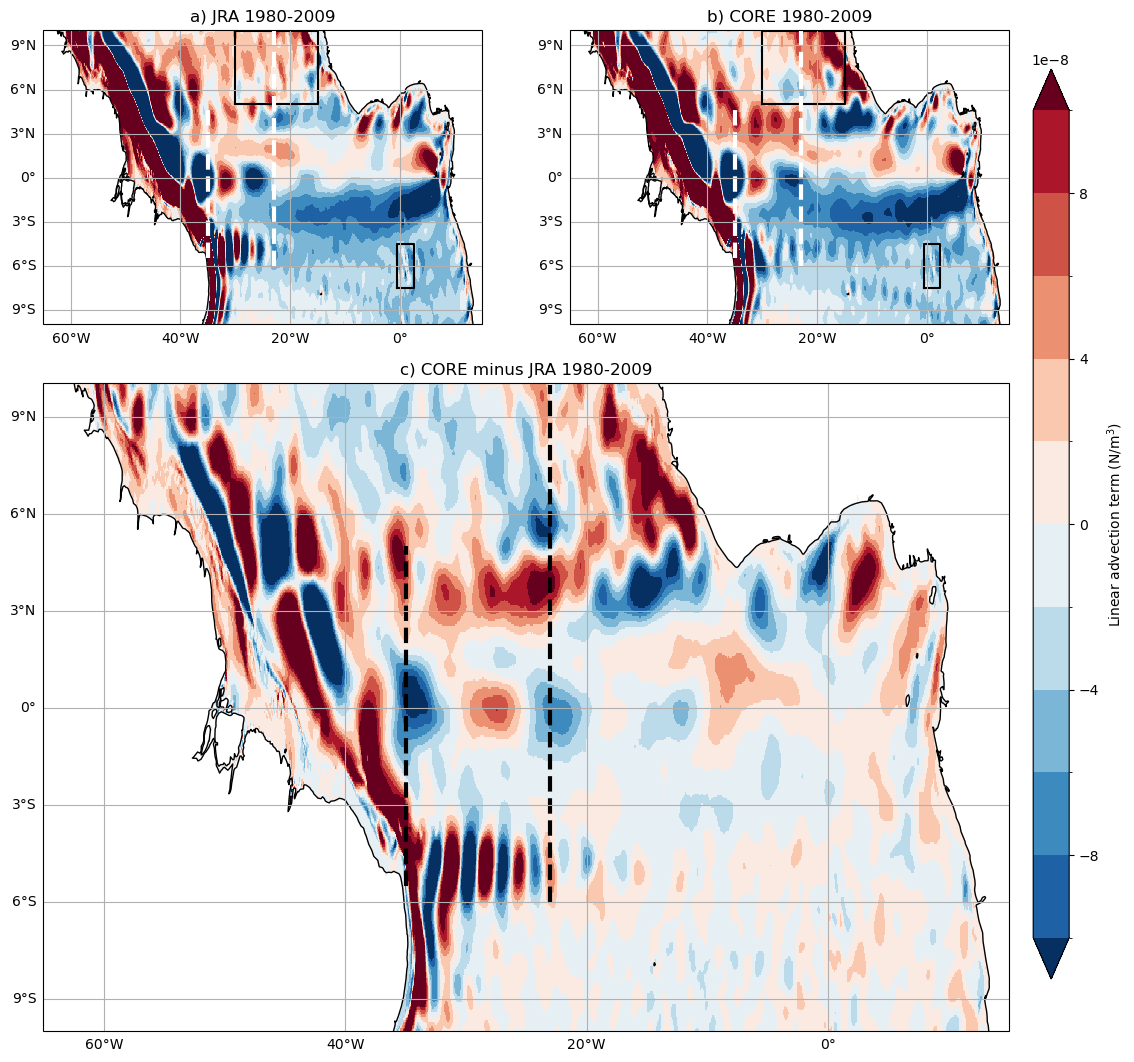

In [11]:
# Quick plot to show the results
tlim1_C,tlim2_C = '1980','2009'
tlim1_J,tlim2_J = '1980','2009'
lw=2
linest='dashed'

data_crs = ccrs.PlateCarree()

# fig, axes = plt.figure(figsize=(12,13)).subplot_mosaic([['a)', 'b)'], ['c)', 'c)'], ['c)', 'c)']],subplot_kw={'projection': ccrs.PlateCarree()})
fig= plt.figure(figsize=(12,13))
axes = fig.subplot_mosaic([['a)', 'b)'], ['c)', 'c)'], ['c)', 'c)']],
                           subplot_kw={'projection': ccrs.PlateCarree()})

im = plot_results(ds_mean.Linear_advection_500m,'JRA',data_crs,axes['a)'])
# EUC_JRA.Y_CM.sel(time_counter=slice(tlim1_C,tlim2_C)).mean(dim=['time_counter']).plot.line('k',ax=axes['a)'],linestyle=linest,transform=data_crs,linewidth=lw)
# NEUC_JRA.Y_CM.sel(time_counter=slice(tlim1_C,tlim2_C)).mean(dim=['time_counter']).plot.line('k',ax=axes['a)'],linestyle=linest,transform=data_crs,linewidth=lw)
# SEUC_JRA.Y_CM.sel(time_counter=slice(tlim1_C,tlim2_C)).mean(dim=['time_counter']).plot.line('k',ax=axes['a)'],linestyle=linest,transform=data_crs,linewidth=lw)
# NECC_JRA.Y_CM.sel(time_counter=slice(tlim1_C,tlim2_C)).mean(dim=['time_counter']).plot.line('k',ax=axes['a)'],transform=data_crs,linewidth=lw)
# nSECu_JRA.Y_CM.sel(time_counter=slice(tlim1_C,tlim2_C)).mean(dim=['time_counter']).plot.line('k',ax=axes['a)'],transform=data_crs,linewidth=lw)
# plot_sv_contour(T_sv,'JRA',data_crs,axes['a)'])
axes['a)'].plot([-30,-15,-15,-30,-30],[5,5,10,10,5],'k')
axes['a)'].plot([-0.5,2.5,2.5,-.5,-.5],[-7.5,-7.5,-4.5,-4.5,-7.5],'k')

im = plot_results(ds_mean.Linear_advection_500m,'CORE',data_crs,axes['b)'])
# EUC_CORE.Y_CM.sel(time_counter=slice(tlim1_C,tlim2_C)).mean(dim=['time_counter']).plot.line('k',ax=axes['b)'],linestyle=linest,transform=data_crs,linewidth=lw)
# NEUC_CORE.Y_CM.sel(time_counter=slice(tlim1_C,tlim2_C)).mean(dim=['time_counter']).plot.line('k',ax=axes['b)'],linestyle=linest,transform=data_crs,linewidth=lw)
# SEUC_CORE.Y_CM.sel(time_counter=slice(tlim1_C,tlim2_C)).mean(dim=['time_counter']).plot.line('k',ax=axes['b)'],linestyle=linest,transform=data_crs,linewidth=lw)
# NECC_CORE.Y_CM.sel(time_counter=slice(tlim1_C,tlim2_C)).mean(dim=['time_counter']).plot.line('k',ax=axes['b)'],transform=data_crs,linewidth=lw)
# nSECu_CORE.Y_CM.sel(time_counter=slice(tlim1_C,tlim2_C)).mean(dim=['time_counter']).plot.line('k',ax=axes['b)'],transform=data_crs,linewidth=lw)
# plot_sv_contour(T_sv,'CORE',data_crs,axes['b)'])
axes['b)'].plot([-30,-15,-15,-30,-30],[5,5,10,10,5],'k')
axes['b)'].plot([-0.5,2.5,2.5,-.5,-.5],[-7.5,-7.5,-4.5,-4.5,-7.5],'k')

im = plot_results(ds_mean.Linear_advection_500m,'DIFF',data_crs,axes['c)'])

axes['b)'].vlines(-23, -6,10, colors='w',linestyles='dashed',linewidths=3)
axes['b)'].vlines(-35, -5.5,5, colors='w',linestyles='dashed',linewidths=3)

axes['a)'].vlines(-23, -6,10, colors='w',linestyles='dashed',linewidths=3)
axes['a)'].vlines(-35, -5.5,5, colors='w',linestyles='dashed',linewidths=3)

axes['c)'].vlines(-23, -6,10, colors='k',linestyles='dashed',linewidths=3)
axes['c)'].vlines(-35, -5.5,5, colors='k',linestyles='dashed',linewidths=3)

axes['a)'].set_title('a) JRA 1980-2009')
axes['b)'].set_title('b) CORE 1980-2009')
axes['c)'].set_title('c) CORE minus JRA 1980-2009')

fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
cb =fig.colorbar(im, cax=cbar_ax, extend='both')
cb.set_label('Linear advection term (N/m$^3$)')